### Ucitavanje neophodnih biblioteka za kreiranje LSTM modela

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

In [7]:
tf.random.set_seed(7)

### Ucitavanje i rad sa skupom podataka

In [8]:
df = pd.read_excel('../data/voce.xlsx')

In [9]:
banane_df = df[df['Naziv_proizvoda'] == 'Banane']
narandze_df = df[df['Naziv_proizvoda'] == 'Narandže']

In [10]:
banane_df_sorted = banane_df.sort_values(by='Nedelja').reset_index(drop=True)
narandze_df_sorted = narandze_df.sort_values(by='Nedelja').reset_index(drop=True)

if banane_df_sorted['Nedelja'].equals(narandze_df_sorted['Nedelja']):
    print("Oba DataFrame-a imaju iste 'Nedelja' vrednosti u istom redosledu.")
else:
    print("Nedelja vrednosti se razlikuju ili nisu u istom redosledu.")

Oba DataFrame-a imaju iste 'Nedelja' vrednosti u istom redosledu.


In [11]:
merged_df = pd.merge(narandze_df, banane_df, on='Nedelja', how='outer', suffixes=('_Narandze', '_Banane'))
merged_df = merged_df[['Nedelja', 'Kolicina_Banane', 'Kolicina_Narandze']]
print(merged_df)

        Nedelja  Kolicina_Banane  Kolicina_Narandze
0    01.04.2024              8.0                3.0
1   01.09.2023.              4.0                0.0
2   01.12.2023.              7.0                4.0
3   02.02.2024.              5.0                3.0
4   02.06.2023.              9.0                8.0
..          ...              ...                ...
84  29.09.2023.              4.0                3.0
85  30.06.2023.              7.0                5.0
86   30.09.2022              3.0                5.0
87  31.03.2023.              9.0                8.0
88    8.04.2024              7.0                3.0

[89 rows x 3 columns]


In [12]:
merged_df.isna().sum()

Nedelja              0
Kolicina_Banane      0
Kolicina_Narandze    0
dtype: int64

In [13]:
merged_df['Nedelja'] = pd.to_datetime(merged_df['Nedelja'], format='mixed', dayfirst=True)
merged_df.set_index('Nedelja', inplace=True)
merged_df = merged_df.sort_index()
merged_df

,Kolicina_Banane,Kolicina_Narandze
Nedelja,,
2022-08-03,10.5,4.5
2022-08-19,3.0,3.0
2022-08-26,3.0,3.0
2022-09-09,3.0,2.0
2022-09-16,4.0,4.0
...,...,...
2024-06-21,7.0,4.0
2024-06-28,7.0,4.0
2024-07-05,7.0,4.0


In [15]:
sve_nedelje = pd.date_range(start=merged_df.index.min(), end=merged_df.index.max(), freq='W-FRI')
sve_nedelje

DatetimeIndex(['2022-08-05', '2022-08-12', '2022-08-19', '2022-08-26',
               '2022-09-02', '2022-09-09', '2022-09-16', '2022-09-23',
               '2022-09-30', '2022-10-07',
               ...
               '2024-05-17', '2024-05-24', '2024-05-31', '2024-06-07',
               '2024-06-14', '2024-06-21', '2024-06-28', '2024-07-05',
               '2024-07-12', '2024-07-19'],
              dtype='datetime64[ns]', length=103, freq='W-FRI')

In [16]:
def proveri_preskocene_nedelje(df):
    nedostajuce_nedelje = sve_nedelje[~sve_nedelje.isin(df.index)]

    if not nedostajuce_nedelje.empty:
        print("Preskočene nedelje u beleženju količine:")
        print(nedostajuce_nedelje)
    else:
        print("Nema preskočenih nedelja u beleženju količine.")


In [17]:
proveri_preskocene_nedelje(merged_df)

Preskočene nedelje u beleženju količine:
DatetimeIndex(['2022-08-05', '2022-08-12', '2022-09-02', '2022-12-23',
               '2022-12-30', '2023-03-24', '2023-07-21', '2023-07-28',
               '2023-08-04', '2023-10-20', '2023-12-29', '2024-02-09',
               '2024-02-23', '2024-03-01', '2024-03-08', '2024-04-05',
               '2024-04-12', '2024-04-19', '2024-04-26', '2024-05-03',
               '2024-05-10', '2024-05-17', '2024-05-31'],
              dtype='datetime64[ns]', freq=None)


In [18]:
merged_df = merged_df.reindex(sve_nedelje)
merged_df.index.name = 'Nedelja'
print(merged_df)
print(merged_df.isna().sum())

            Kolicina_Banane  Kolicina_Narandze
Nedelja                                       
2022-08-05              NaN                NaN
2022-08-12              NaN                NaN
2022-08-19              3.0                3.0
2022-08-26              3.0                3.0
2022-09-02              NaN                NaN
...                     ...                ...
2024-06-21              7.0                4.0
2024-06-28              7.0                4.0
2024-07-05              7.0                4.0
2024-07-12              7.0                3.0
2024-07-19              7.0                3.0

[103 rows x 2 columns]
Kolicina_Banane      23
Kolicina_Narandze    23
dtype: int64


In [19]:
merged_df.fillna(0, inplace=True)
print(merged_df)
print(merged_df.isna().sum())

            Kolicina_Banane  Kolicina_Narandze
Nedelja                                       
2022-08-05              0.0                0.0
2022-08-12              0.0                0.0
2022-08-19              3.0                3.0
2022-08-26              3.0                3.0
2022-09-02              0.0                0.0
...                     ...                ...
2024-06-21              7.0                4.0
2024-06-28              7.0                4.0
2024-07-05              7.0                4.0
2024-07-12              7.0                3.0
2024-07-19              7.0                3.0

[103 rows x 2 columns]
Kolicina_Banane      0
Kolicina_Narandze    0
dtype: int64


In [20]:
merged_df.loc['2022-08-05', 'Kolicina_Banane'] = 10.5
merged_df.loc['2022-08-05', 'Kolicina_Narandze'] = 4.5

In [21]:
def popuni_nedostajuce_vrednosti(df):
    new_df = df.copy()
    
    new_df['Kolicina_Banane'] = new_df['Kolicina_Banane'].mask(new_df['Kolicina_Banane'] == 0).interpolate(method='linear')
    new_df['Kolicina_Banane'] = new_df['Kolicina_Banane'].bfill()
    
    new_df['Kolicina_Narandze'] = new_df['Kolicina_Narandze'].mask(new_df['Kolicina_Narandze'] == 0).interpolate(method='linear')
    new_df['Kolicina_Narandze'] = new_df['Kolicina_Narandze'].bfill()

    return new_df

In [22]:
merged_df_no_na = popuni_nedostajuce_vrednosti(merged_df)
merged_df_no_na[merged_df_no_na['Kolicina_Banane']==0], merged_df_no_na[merged_df_no_na['Kolicina_Narandze']==0]

(Empty DataFrame
 Columns: [Kolicina_Banane, Kolicina_Narandze]
 Index: [],
 Empty DataFrame
 Columns: [Kolicina_Banane, Kolicina_Narandze]
 Index: [])

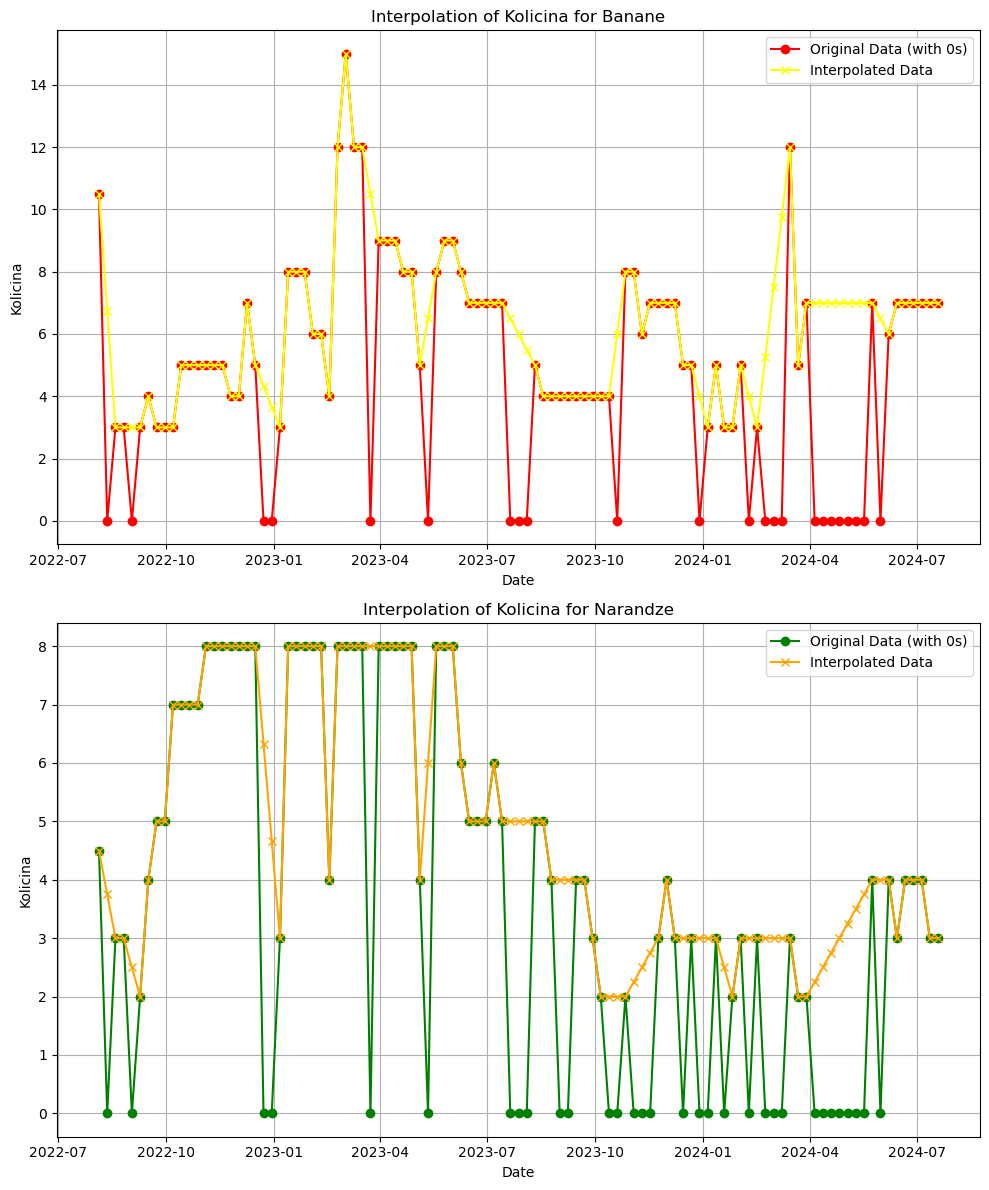

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12)) 

ax1.plot(merged_df.index, merged_df['Kolicina_Banane'], marker='o', label='Original Data (with 0s)', color='red')
ax1.plot(merged_df_no_na.index, merged_df_no_na['Kolicina_Banane'], marker='x', label='Interpolated Data', color='yellow')
ax1.set_title('Interpolation of Kolicina for Banane')
ax1.set_xlabel('Date')
ax1.set_ylabel('Kolicina')
ax1.legend()
ax1.grid()

ax2.plot(merged_df.index, merged_df['Kolicina_Narandze'], marker='o', label='Original Data (with 0s)', color='green')
ax2.plot(merged_df_no_na.index, merged_df_no_na['Kolicina_Narandze'], marker='x', label='Interpolated Data', color='orange')
ax2.set_title('Interpolation of Kolicina for Narandze')
ax2.set_xlabel('Date')
ax2.set_ylabel('Kolicina')
ax2.legend()
ax2.grid()

plt.tight_layout()

plt.show()

In [24]:
banane_narandze = merged_df_no_na

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
banane_narandze['Skalirana_kolicina_banana'], banane_narandze['Skalirana_kolicina_narandzi'] = scaler.fit_transform(banane_narandze[['Kolicina_Banane']]), scaler.fit_transform(banane_narandze[['Kolicina_Narandze']])

In [26]:
banane_narandze.head()

,Kolicina_Banane,Kolicina_Narandze,Skalirana_kolicina_banana,Skalirana_kolicina_narandzi
Nedelja,,,,
2022-08-05,10.50,4.50,0.6250,0.416667
2022-08-12,6.75,3.75,0.3125,0.291667
2022-08-19,3.00,3.00,0.0000,0.166667
2022-08-26,3.00,3.00,0.0000,0.166667
2022-09-02,3.00,2.50,0.0000,0.083333


In [27]:
train_data = banane_narandze[banane_narandze.index < '2024-04-01'].sort_values('Nedelja')
test_data = banane_narandze[banane_narandze.index >= '2024-04-01'].sort_values('Nedelja')
test_data

,Kolicina_Banane,Kolicina_Narandze,Skalirana_kolicina_banana,Skalirana_kolicina_narandzi
Nedelja,,,,
2024-04-05,7.0,2.25,0.333333,0.041667
2024-04-12,7.0,2.50,0.333333,0.083333
2024-04-19,7.0,2.75,0.333333,0.125000
2024-04-26,7.0,3.00,0.333333,0.166667
2024-05-03,7.0,3.25,0.333333,0.208333
2024-05-10,7.0,3.50,0.333333,0.250000
2024-05-17,7.0,3.75,0.333333,0.291667
2024-05-24,7.0,4.00,0.333333,0.333333
2024-05-31,6.5,4.00,0.291667,0.333333


In [28]:
def kreiraj_sekvence(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i: (i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

In [30]:
look_back = 1

In [31]:
X_train, y_train = kreiraj_sekvence(train_data, look_back)
X_test, y_test = kreiraj_sekvence(test_data, look_back)

InvalidIndexError: (slice(0, 1, None), slice(None, None, None))